In [1]:
import h5py
import numpy as np
import numpy.ma as ma
import scipy
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from astropy.stats import LombScargle
import datetime
from datetime import date

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def defining_variables(ISRdata):
    
    """
    Defines varibles needed for each function from each file.
    """
    all_electron_density = np.array(ISRdata['NeFromPower/Ne_NoTr'])
    all_altitude = np.array(ISRdata['NeFromPower/Altitude'])
    altitude_slice = np.array(all_altitude[0,:])
    altitude_slice_km = altitude_slice/1000.
    lower_limit = 100.
    upper_limit = 500.
    all_time = np.array(ISRdata['Time/UnixTime'])
    time_slice_seconds = np.array(all_time[:,0])
    
    return all_electron_density,altitude_slice_km,time_slice_seconds,lower_limit,upper_limit

In [3]:
def time_by_day(time_slice_seconds):
    """
    Breaks time array into 24-hour blocks.
    """
    time_1D = time_slice_seconds.ravel()
    year_array = np.array([])
    month_array = np.array([])
    day_array = np.array([])
    hour_array = np.array([])
    day_difference_array = np.array([])
    days_in_data = np.array([])
    days_in_data = np.array([])
    day_indices = np.array([])

    for i in range(len(time_slice_seconds)):
        date_value = datetime.datetime.fromtimestamp(time_1D[i])
        
        day_value = date_value.day
        day_array = np.append(day_array,day_value)
        
        hour_value = date_value.hour
        hour_array = np.append(hour_array, hour_value)

    for i in range(len(day_array)):
        day_difference = day_array[i] - day_array[0]
        day_difference_array = np.append(day_difference_array, day_difference)
    
    day_difference_list = day_difference_array.tolist()
    
    for i in range(len(day_difference_list)):
    
        if i in day_difference_list:
            index = day_difference_list.index(i)
    
            day_indices = np.append(day_indices, index)
        
            days_in_data = np.append(days_in_data,i)
            amount_of_days = range(len(days_in_data))
    
    day_indices = np.append(day_indices, len(day_difference_list))
    day_indices_list = day_indices.tolist()
        
    return day_array,amount_of_days,hour_array,day_indices_list

In [4]:
def altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density):
    """
    Returns the indices for the lower and upper limits of altitude.
   
    Based on the limits defined in 'defining_variables'.
    """
    min_val_low = np.abs(altitude_no_bounds[0]-lower_limit)
    min_val_up = np.abs(altitude_no_bounds[0]-upper_limit)
    
    for i in range(len(altitude_no_bounds)):
        diff_low = np.abs(altitude_no_bounds[i]-lower_limit)
        if diff_low < min_val_low:
            min_val_low = diff_low
            lower_ind = i
            
        diff_up = np.abs(altitude_no_bounds[i]-upper_limit)
        if diff_up < min_val_up:
            min_val_up = diff_up
            upper_ind = i
    upper_ind = upper_ind + 1   
    altitude = altitude_no_bounds[lower_ind:upper_ind]
    e_density = e_density[:,:,lower_ind:upper_ind]
    
    return altitude,e_density


In [5]:
def Ne_function(e_density,altitude,day_indices_list,time_slice_seconds):
    """
    Plots the electron density as a function of altitude and time.
    """
    e_den_array = np.array([])
    new_hour_array = np.array([])
    
    year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
    #######################PLOT#########################
    figure_size = ['','']
    figure_size[0] = 14
    figure_size[1] = 4
    plt.rcParams["figure.figsize"] = figure_size
    ymin, ymax = altitude[0], altitude[-1]
    y = np.linspace(ymin, ymax, e_density.shape[2])
    xmin, xmax = time_slice_seconds[0], time_slice_seconds[-1]
    x = np.linspace(xmin, xmax, e_density.shape[0])
    Y,X = np.meshgrid(y,x)
    Z = np.array(e_density[:,0,:])
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Z, norm = colors.LogNorm(vmin = 10**9.5, vmax = 10**11.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    cbar = fig.colorbar(im, orientation = 'vertical', pad = .01)
    cbar.set_label('Ne - noTr $[m^{-3}]$',fontsize = 14)
    plt.title('el = 90 deg, Date: {}'.format(year_month_day))
    plt.xlabel('UTC [Hr]')
    plt.ylabel('Altitude [km]')
    plt.tight_layout()
    #######################PLOT#########################
        
    e_den_array = np.append(e_den_array,e_density)
    new_hour_array = np.append(new_hour_array,time_slice_seconds)
        
    return e_den_array

In [6]:
def butter_lowpass(cutoff, fs, order):
    
    """
    Defines butter low pass filter.
    
    Used in rel_e_den_array_function.
    """
    
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [7]:
def interpolation_function(time_slice_seconds,e_density):
    """
    Takes in Ne array and returns relative Ne array.

    Applies a low pass filter on the Ne array to give the relative perturbation.

    (Low Pass Filter passes through low frequencies and decreases the amplitude of high frequencies)
    """
    #Define time array w/ spacing similar to original time sampling
    t = np.linspace(time_slice_seconds[0],time_slice_seconds[-1],int(time_slice_seconds.size))
    # Filter requirements.
    order = 6
    sampling_period_sec = t[1] - t[0]
    fs = float(1) / float(sampling_period_sec) # sampling frequency, Hz
    cutoff = float(1) / float(2*3600) # desired cutoff frequency of the filter, Hz
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)
        
    time_size = e_density.shape[0]
    alt_size = e_density.shape[2]
    # Setting arrays equal to zero array
    Ne_reg_sampled_array = np.zeros((4,time_size,alt_size))
    Ne_filtered_array = np.zeros((4,time_size,alt_size)) # background densities
    rel_e_densities = np.zeros((4,time_size,alt_size))
    for num in range(4):
        for n in range(alt_size):
            Ne_alt_bin = e_density[:,num,n] # 1-D Ne array for altitude 0 and pole 0
            Ne_alt_bin_m1 = ma.masked_less_equal(Ne_alt_bin,0) # masking negative electron densities
            Ne_alt_bin_m2 = np.ma.masked_invalid(Ne_alt_bin_m1) # masking NaN values
            #Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
            Ne_index = ma.nonzero(Ne_alt_bin_m2)
            if len(Ne_index[0]) > 2:
                time_mask_removed = np.copy(time_slice_seconds)
                # Setting masked values in time array to 0
                for j in range(time_size):
                    if np.isin(j,Ne_index) == False:
                        time_mask_removed[j] = 0
                # Removing zero values from time array   
                time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
                # Removing masked values from Ne array
                Ne_for_interp = ma.compressed(Ne_alt_bin_m2) 
                # Defining interpolation function for Ne (as function of time)
                interp_fun_Ne = interp1d(time_interp, Ne_for_interp,kind='cubic')
                #Setting up Ne arry
                t1 = time_interp[0]
                t2 = time_interp[-1]
                Ne_reg_sampled = np.piecewise(t,[t<t1,(t1<=t)&(t<=t2),t>t2],[0,lambda t: interp_fun_Ne(t),0])
                #Filter data passed through filtfilt to get response curve
                Ne_filtered = filtfilt(b,a,Ne_reg_sampled)
            else:
                Ne_reg_sampled = np.zeros(time_size)
                Ne_filtered = np.zeros(time_size)
            Ne_reg_sampled_array[num,:,n] = Ne_reg_sampled 
            Ne_filtered_array[num,:,n] = Ne_filtered
        rel_e_densities[num,:,:]=(Ne_reg_sampled_array[num,:,:]-Ne_filtered_array[num,:,:])/Ne_filtered_array[num,:,:]
            
    return Ne_filtered_array,t,rel_e_densities

In [8]:
def background_e_den_function(e_density,day_indices_list,time_slice_seconds,altitude):
    """
    Plots the background electron density.
    """
    background_array = np.array([])
    
    year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
    Ne_filtered_array,t,rel_e_densities = interpolation_function(time_slice_seconds,e_density)
        
        #######################PLOT#########################
    fig_size = ['','']
    fig_size[0] = 14
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    Y, X = np.meshgrid(altitude,t)
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Ne_filtered_array[0,:,:],norm = colors.LogNorm(vmin = 10**9.5, vmax=10**11.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    cbar = fig.colorbar(im, orientation = "vertical", pad = .01)
    cbar.set_label('$ N_{e0} \ [m^{-3}]$',fontsize = 14)
    plt.title('Background Electron Density, Date: {}'.format(year_month_day))
    plt.xlabel('UTC [Hr]')
    plt.ylabel('Altitude [km]')
    plt.tight_layout()
        #######################PLOT#########################
        
    background_array = np.append(background_array,Ne_filtered_array)
        
    return background_array

In [9]:
def relative_e_den_function(e_density,day_indices_list,time_slice_seconds,altitude):
    """
    Plots the derived relative electron density.
    """
    new_time_array = np.array([])
    relative_array = np.array([])
    
    year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
    Ne_filtered_array,t,rel_e_densities = interpolation_function(time_slice_seconds,e_density)
   
        #######################PLOT#########################
    fig_size = ['','']
    fig_size[0] = 14
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    t = t - t[0]
    Y, X = np.meshgrid(altitude,t)
    Z3 = rel_e_densities[0,:,:]
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Z3, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    cbar = fig.colorbar(im, orientation = "vertical", pad = .01)
    cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize = 14)
    plt.title('Relative Electron Density, Date: {}'.format(year_month_day))
    plt.xlabel('UT [Hr]')
    plt.ylabel('Altitude [km]')
    plt.tight_layout()
        #######################PLOT#########################

    new_time_array = np.append(new_time_array,time_slice_seconds)
    relative_array = np.append(relative_array,rel_e_densities)
        
    return new_time_array,relative_array

In [10]:
def lomb_scargle_spectrogram_function(time_slice_seconds,day_indices_list,e_density,altitude):
    """
    Plots the lomb scargle spectrogram.
    """
    lomb_scargle_spectrogram_array = np.array([])
    
    year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
    Ne_filtered_array,t,rel_e_densities = interpolation_function(time_slice_seconds,e_density)
    
    fig_size = ['','']
    fig_size[0] = 12
    fig_size[1] = 16
    plt.rcParams["figure.figsize"] = fig_size
    fig, axes = plt.subplots(16, 1, sharex=True)
    subplt_num = 15

    rel_Ne = rel_e_densities[0,:,:] #beam 0 is used
    freq_len = 100
    frequency = np.linspace(.1,3.5,freq_len)
    t_power = np.zeros(41) ####t_power = ap.array([])
                           #### 41 = len(t_power)
    dx = t_power[1] - t_power[0]
    dy = frequency[1] - frequency[0]
    alt_num = 0
    cmap = 'jet'
    #---------------
    for alt_bin in range(125,525,25): ####altitude range in auto calculated, just need range of it?
        avg_spec = np.zeros((41,freq_len))  #### want to use len(t_power) instead
        norm = 0
        while(altitude[alt_num] < float(alt_bin)):
            ti = 0
            power_spec = np.zeros((41,freq_len))
            for k in range(0,(len(t)-23),4):
                Ne_rel_bin = rel_Ne[k:23+k,alt_num]
                t_sample = t[k:23+k]
                t_power[ti] = t_sample[12]
                power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
                ti += 1
            avg_spec += power_spec
            alt_num += 1
            norm += 1
        avg_spec = (avg_spec / float(norm))
        Yspec,Xspec = np.meshgrid(frequency,t_power)
        # Plotting averaged spectrogram subplot for subplot
        im2 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
        y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
        axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=28)
        axes[subplt_num].tick_params(
            axis = 'y',
            left=False,
            right=False,
            labelleft=False,
            labelright=True)
        axes[subplt_num].tick_params(
            axis = 'x',
            bottom=False)
        axes[subplt_num].set_xlim([11, 25])
        # Want to plot from bottom to top    
        subplt_num -= 1
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
    cax1 = fig.add_axes([0.87,0.3,0.02,0.4])
    cbar = plt.colorbar(im2,cax=cax1,orientation='vertical')
    cbar.set_label('LS Power',fontsize=14)
    fig.text(0.45, 0.07, 'UT [Hr]', ha='center', va='center', fontsize = 14)
    fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 14)
    fig.text(0.85, 0.13,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 14)
    plt.tight_layout()
    #plt.savefig('{}_spectrogram.png'.format(year_month_day))
    
    #lomb_scargle_spectrogram_array = np.append()
    
    #return lomb_scargle_spectrogram_array

In [11]:
def lomb_scargle_periodogram_function(amount_of_days,time_slice_seconds,day_indices_list,altitude):
    """
    Plots the lomb scargle periodogram.
    """
    lomb_scargle_periodogram_array = np.array([])
    
    fig_size = ['','']
    fig_size[0] = 12
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    fig, axes = plt.subplots(4, 1, sharex=True)
    subplt_num = 3

    freq_len = 100
    frequency = np.linspace(.1,3.5,freq_len)
    t_power = np.zeros(41)
    dx = t_power[1] - t_power[0]
    dy = frequency[1] - frequency[0]
    alt_num = 0
    cmap = 'jet'
    #---------------
    for alt_bin in range(225,325,25):
        avg_spec = np.zeros((41,freq_len))
        norm = 0
        while(altitude[alt_num] < float(alt_bin)):
            ti = 0
            power_spec = np.zeros((41,freq_len))
            for k in range(0,(len(t)-23),4):
                Ne_rel_bin = rel_e_densities[k:23+k,alt_num]
                t_sample = t[k:23+k]
                t_power[ti] = t_sample[12]
                power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
                ti += 1
            avg_spec += power_spec
            alt_num += 1
            norm += 1
        avg_spec = (avg_spec / float(norm))
        Yspec,Xspec = np.meshgrid(frequency,t_power)
        # Plotting averaged spectrogram subplot for subplot
        im1 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
        y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
        axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=38,fontsize = 14)
        axes[subplt_num].tick_params(
            axis = 'y',
            left=False,
            right=False,
            labelleft=False,
            labelright=True,
            labelsize = 14)
        axes[subplt_num].tick_params(
            axis = 'x',
            bottom=False,
            labelsize = 14)
        axes[subplt_num].set_xlim([11, 25])
        # Want to plot from bottom to top    
        subplt_num -= 1
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
    cax1 = fig.add_axes([0.88,0.18,0.02,0.7])
    cbar = plt.colorbar(im1,cax=cax1,orientation='vertical')
    cbar.set_label('LS Power',fontsize=16)
    fig.text(0.45, 0.03, 'UT [Hr]', ha='center', va='center', fontsize = 18)
    fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 18)
    fig.text(0.85, 0.195,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 18)
    plt.tight_layout()
    #plt.savefig('{}_periodogram.png'.format(year_month_day))
    
    #lomb_scargle_periodogram_array = np.append()
    
    return lomb_scargle_periodogram_array

In [12]:
def h5_files(time_slice_seconds,e_den_array,altitude,new_time_array,day_array,amount_of_days,hour_array,background_array,relative_array):
    
    t1 = time_slice_seconds[0]
    year_month_day = date.fromtimestamp(t1)
    
    with h5py.File('/Users/tedipro/Desktop/{}.h5'.format(year_month_day),'a') as hdf:
        Ne_NoTr = hdf.create_group('Ne_NoTr')
        e_density = Ne_NoTr.create_dataset('e_density', data = e_den_array)
    
        Alt = hdf.create_group('Altitude')
        alt = Alt.create_dataset('alt', data = altitude)
    
        Time = hdf.create_group('Time')
        UnixTime = Time.create_dataset('UnixTime', data = new_time_array)
        Day = Time.create_dataset('Day', data = day_array)
        amount_of_days = Time.create_dataset('Total_Days', data = amount_of_days)
        Hours = Time.create_dataset('Hours', data = hour_array)
    
        Backgrd_Ne = hdf.create_group('Backgrd_Ne')
        backgrd_Ne = Backgrd_Ne.create_dataset('backgrd_Ne', data = background_array)
    
        Relative_Ne = hdf.create_group('Relative_Ne')
        relative_Ne = Relative_Ne.create_dataset('relative_Ne', data = relative_array)
    
        LS = hdf.create_group('LS')
        frequency = LS.create_dataset('frequency', data = np.random.random(size = (10,10)))
        spectrogram = LS.create_dataset('spectrogram', data = np.random.random(size = (10,10)))
        periodogram = LS.create_dataset('periodogram', data = np.random.random(size = (10,10)))


In [13]:
def e_density_data(file_name):
    
    e_density,altitude_no_bounds,time_slice_seconds,lower_limit,upper_limit = defining_variables(file_name)
    
    day_array,amount_of_days,hour_array,day_indices_list = time_by_day(time_slice_seconds)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    e_den_array = Ne_function(e_density, altitude,day_indices_list,time_slice_seconds)
    
    background_array = background_e_den_function(e_density,day_indices_list,time_slice_seconds,altitude)
    
    new_time_array,relative_array = relative_e_den_function(e_density,day_indices_list,time_slice_seconds,altitude)
    
    #lomb_scargle_spectrogram_array = 
    lomb_scargle_spectrogram_function(time_slice_seconds,day_indices_list,e_density,altitude)
    
    #lomb_scargle_periodogram_array = lomb_scargle_periodogram_function(amount_of_days,time_slice_seconds,day_indices_list,altitude)
    
    #h5_files(time_slice_seconds,e_den_array,altitude,new_time_array,day_array,amount_of_days,hour_array,background_array,relative_array)

IndexError: index 41 is out of bounds for axis 0 with size 41

/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


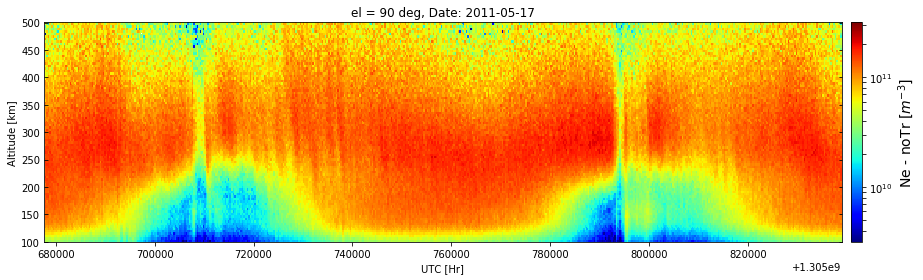

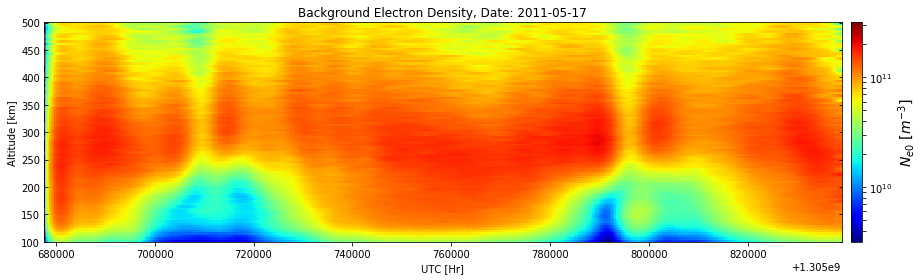

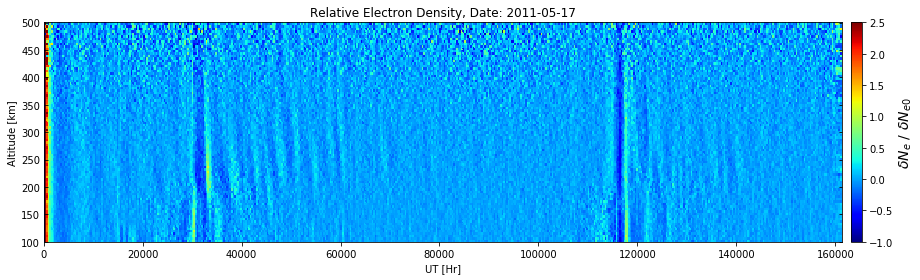

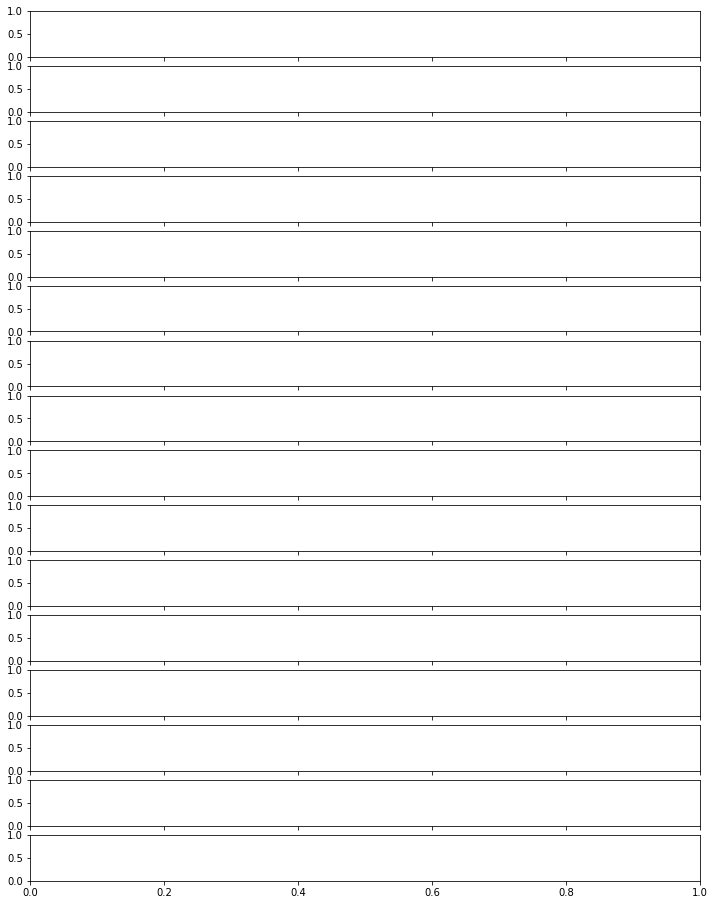

In [14]:
files = glob.glob('/home/tgodfrey/Downloads/20110518.001_lp_5min-cal.h5')

for i in range(len(files)):
    file_name = h5py.File(files[i],'r')
    e_density_data(file_name)
    file_name.close()
